Cloud Masking in python using VIIRS
================================

Cloud masking is an very common problem for remote sensing; clouds often contaminate signals (like ICESat returns), or completely obscure spectral data for visible and multispectral sensors (like Landsat, or commercial imagery). There are two common approaches to masking out clouds:

1. Use data within the image or remote sensing signal to flag cloud retrievals
2. Use data from another sensor to mask clouds

The first option is sensor specific; it benefits enormously from the fact that there is no spacio-temporal mismatch in the data. However, since it is sensor specific, the efficacy varies widely-- some sensors have the spectral resolution to have a dedicated cloud detection band or bands... but some sensors will rely on decision trees for cloud classification (which isn't physically based), or signal attenuation (which yields high errors of both omission and commission). While per sensor cloud masking tends to be more common, we'll actually focus on the other method here.

Using data from another sensor has some major benefits. It enables a consistent, physically based method to remove clouds across data products. The source data for cloud masking-- VIIRS here, although MODIS is the other major candidate -- acquires data over the entire earth at least twice a day, with ***much*** higher frequencies of revisits at the poles. The data from both MODIS and VIIRS are well known and trusted by the remote sensing community; their cloud products are reliable, and have their own independent QAQC. However, using a different sensor to provide a cloud mask has it's own challenges: 

1. The data isn't coincident in time
2. The resolutions are almost certainly different
3. The data acquisition grids aren't aligned

We'll show a simple real world use case here.

Processing pipeline
----------------------------

I'll refer the image that we want correct as the 'target', and the image that we are retrieving cloud data from as the 'source'. There are 3 basic steps for cloud masking:

1. Determine the VIIRS/MODIS Granules needed (source granules)
2. Extract the cloud/non-cloud coordinates
3. Determine which target pixels are cloud contaminated

We'll largely ignore step 1 in this notebook; we pick a study area, and manually download the granules that match the area. Obviously, we would want to automate this, either with a spatial query and bounded time slices, or with reference to known repeat ground tracks. Step 2 is fairly simple, and can be accomplished multiple ways... however, step 3 induces some resolution dependent considerations. 

If the target pixels (or laser footprints) are smaller than the VIIRS/MODIS cloud mask source pixels, simple nearest neighbor calculations tend to suffice-- the VIIRS/MODIS lat/lon coordinates are for the center of the observation, so for for each target coordinate that you want to mask, check to see what the closest source coordinate is. If the closest source pixel coordinate is a cloud, mask it, and if the coordinate isn't a cloud, don't mask it. Nearest neighbor calculations for distance metrics that obey the triangle inequality (e.g., both euclidean and haversine distances), tend to be quite fast if you just need to know what the neighbor index is, instead of knowing the exact distance... that said, cheap calculations get expensive when you have do millions or billions of them. If you didn't want to build spatial trees for both the cloud and non-cloud values, you could build for just the cloud coordinates, retrieve the index, and then calculate the single distance from the closest cloud using a distance threshold to decide if the area is cloud free for cheaper; or you could also do them on a GPU. There are options.

If the target pixels that you are seeking to mask are ***larger*** than the VIIRS/MODIS source pixels, things are a little different. For that case, you normally need to leave spherical coordinates (i.e., convert to a euclidean projection), and then do a chebyshev distance lookup (i.e., square distance)... basically, you're checking to see what the count of cloud pixels inside of your data pixel, and then masking based on some sort of rule ( > 0 , or maybe >= N / 2). Since the target pixels tend to be smaller than the source data, I'll focus on that more common case here and follow up with the special case in a different notebook.

A real world example: Landsat correction
====================

This example is (heavily) modified from [Mahsa's 2016 paper](https://www.sciencedirect.com/science/article/pii/S0034425716302267); for that work, I was actually using MODIS data to look at water vapor and ozone retrievals as possible sources error, since she had already examined the Landsat images by hand for cloud contamination. Since the Landsat images from that project intentionally didn't have clouds, I've grabbed a Landsat scene for the same area that does.

All of the data files referenced here are available in this keybase folder:

https://keybase.pub/espg/cloudmasking/

A nix derivation for building dependcies can be found here. Finally, for anyone interested, there's also the [ipython notebook](https://espg.keybase.pub/cloudmasking/Ozone_MOD07-Mahsa_2nd_img.ipynb) that I did for Mahsa's paper, which extracts water vapor and ozone from MODIS ([as pdf](https://espg.keybase.pub/cloudmasking/Ozone_MOD07-Mahsa_2nd_img.pdf)).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Fixing figure output for all figures
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['figure.dpi'] = 160
rcParams['savefig.dpi'] = 200

In [3]:
import pyproj
import h5py

from osgeo import osr, gdal

from IPython.display import Image

from sklearn.neighbors import BallTree, ball_tree
from joblib import Parallel, delayed

In [4]:
# Define source data locations

b2 = "http://landsat-pds.s3.amazonaws.com/L8/006/013/LC80060132014195LGN00/LC80060132014195LGN00_B2.TIF"
b3 = "http://landsat-pds.s3.amazonaws.com/L8/006/013/LC80060132014195LGN00/LC80060132014195LGN00_B3.TIF" 
b4 = "http://landsat-pds.s3.amazonaws.com/L8/006/013/LC80060132014195LGN00/LC80060132014195LGN00_B3.TIF"

# LS8 aero product mask
aero_mask = "https://espg.keybase.pub/cloudmasking/LC08_L1TP_006013_20140714_20170421_01_T1_sr_aerosol.tif"

#Get source data; gdal will read directly from url, but h5py won't
!wget "https://espg.keybase.pub/cloudmasking/CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc"

--2020-05-17 11:23:37--  https://espg.keybase.pub/cloudmasking/CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc
Resolving espg.keybase.pub (espg.keybase.pub)... 35.171.250.101, 52.3.160.119, 34.232.198.135
Connecting to espg.keybase.pub (espg.keybase.pub)|35.171.250.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52260009 (50M) [application/x-netcdf]
Saving to: ‘CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc.2’

CLDMSK_L2_VIIRS_SNP 100%[===================>]  49.84M  1.73MB/s    in 31s     

2020-05-17 11:24:10 (1.58 MB/s) - ‘CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc.2’ saved [52260009/52260009]



Target Data: Landsat
---------------------

Since we're just taking the spatial data for the Landsat granule, we don't need the actual data file at all-- metadata is fine. That said, it's usually easiest to grab the metadata directly from the geotiff:

In [5]:
# get the existing coordinate system
# may take a sec to download depending on connection speed
ds = gdal.Open(b2)
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())
print(ds.RasterXSize), print(ds.RasterYSize)
print(ds.GetGeoTransform())
ds.GetProjectionRef()

8271
8341
(511785.0, 30.0, 0.0, 7552515.0, 0.0, -30.0)


'PROJCS["WGS 84 / UTM zone 22N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32622"]]'

The information above tells us everything we need to know to setup a spatial grid-- the number samples, number of lines, the upper left corner coordinates in x and y, and the pixel spacing for both x and y, with the UTM and EPSG codes provided as well. The upper left coordinate values are slightly different than what is defined in a NASA metadata file; in the NASA metadata file, the grid is given in relation to the pixel centers. By contrast, the geotiff metadata defines **the edge of the pixel**. Since the pixel spacing is 30 meters, we'll offset by a half pixel to get the grid defined on the center of the pixel coordinates. Note that since the Y coordinates decrease from the upper left corner, the pixel spacing is negative.

In [6]:
ULX = ds.GetGeoTransform()[0] + 15 # Upper left X Coord
Xres = ds.GetGeoTransform()[1]     # Resolution in X dim (positive)
ULY = ds.GetGeoTransform()[3] - 15 # Upper left Y Coord
Yres = ds.GetGeoTransform()[5]     # Resolution in Y dim (negative)

The Landsat imagery data grid is defined in UTM coordinates. We would normally use polar stereographic north for Greenland as it has less distortion... however, if we did that, the pixel spacing would not be linear in that projection. Using UTM coordinates lets us use slice notation and meshgrid to layout the exact pixel locations. So the best practice for Landsat imagery, even if we want data in polar sterographic north, is to lay out a UTM grid, and then transform to EPSG 3116 (if needed).

We need a way to convert from UTM coordinates to lat/long values so that we can calculate distances using spherical great circle distance. We know from above that the UTM zone is 22N (i.e., EPSG code 32622; see https://spatialreference.org/ref/epsg/wgs-84-utm-zone-22n/), so we could just use:

In [7]:
# Manual
p1 = pyproj.Proj(proj='utm',zone=22,ellps='WGS84')

# ...or, the same thing, automated from Landsat file
cs = osr.SpatialReference()
cs.ImportFromWkt(ds.GetProjectionRef())
p2 = pyproj.Proj(cs.ExportToProj4())

In [8]:
# The grid is large enough (~5GB) that it will be a hassle on
# smaller machines =/
print((len(r_[ULX:ULX+(ds.RasterXSize*Xres):Xres]), ds.RasterXSize))
print((len(r_[ULY:ULY+(ds.RasterYSize*Yres):Yres]), ds.RasterYSize))

(8271, 8271)
(8341, 8341)


In [9]:
# Setting up the coordinate grid
LSx , LSy = meshgrid(r_[ULX:ULX+(ds.RasterXSize*Xres):Xres], 
                                 r_[ULY:ULY+(ds.RasterYSize*Yres):Yres]) 
LScoords = np.vstack([LSx.ravel(),LSy.ravel()]).T

In [10]:
# Check if we can invert to UL lat and long
print(p2(LScoords[0,0], LScoords[0,1],inverse=True))
# Double check that p1 and p2 refer to the same transform
print(p1(LScoords[0,0], LScoords[0,1],inverse=True))

(-50.71668082659874, 68.08618253329952)
(-50.71668082659874, 68.08618253329952)


In [11]:
# The coordinate inversion is within machine precision
# Sadly, the current version of proj ignores the radian flag:
p2(LScoords[0,0], LScoords[0,1],inverse=True, radians=True)

(-50.71668082659874, 68.08618253329952)

In [12]:
# So we do our own conversion to radians for distance calculations:
LS_rad = np.vstack(p2(LScoords[:,0], LScoords[:,1],inverse=True)).T
LS_rad *= pi/180
LS_rad[0]

array([-0.88517307,  1.18832806])

Before we move on to the target data, let's get a bit of spatial context and plot our Landsat imagery:

In [13]:
# Stretch functions from Matt (siegfried@mines.edu)
# Creates true color image
def landsat_nat_color(im, gamma=2.0):
    """
    landsat_nat_color takes a landsat band stack and returns
        a natural color image processed similar to what you
        would see as the LandsatLook preview image through a 
        USGS data discovery tool
    im: MxNxB numpy array (B = number of bands)
    """
    return np.dstack((gammacorr(im[:,:,0], gamma),
                        gammacorr(im[:,:,1], gamma),
                        gammacorr(im[:,:,2], gamma)))

def gammacorr(im, gamma):
    """
    gammcorr takes a single band image and applies a
        gamma stretch at the level specificed
    im:    MxN numpy array
    gamma: gamma stretch exponent (float)
    """
    pixels = im.flatten()
    minval = np.percentile(pixels, 0)
    maxval = np.percentile(pixels,100)
    im2 = (pixels - minval)/(maxval - minval)
    im2[im2<0] = 0
    im2[im2>1] = 1
    im2 = np.power(im2, 1/gamma)
    return im2.reshape(im.shape)

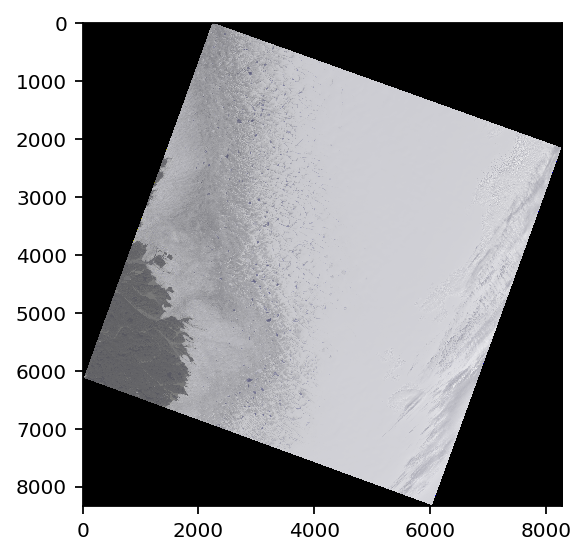

In [14]:
# may take a sec to download depending on connection speed
ls8 = np.zeros((ds.RasterYSize, ds.RasterXSize, 3))
ls8[:,:,2] = gdal.Open(b2).ReadAsArray(0)
ls8[:,:,1] = gdal.Open(b3).ReadAsArray(0)
ls8[:,:,0] = gdal.Open(b4).ReadAsArray(0)
LSC = landsat_nat_color(ls8)
imshow(LSC)

This area is the same as Mahsa's 2016 paper looks at-- around Russell glacier, in Southwest Greenland. The date of the image is July 14th, 2014; acquisition time for center of the image is 14:42:28.18 UTC. This image has a few features that make it a useful example-- mainly, the cloud bank in the east of the image, and that since we're looking in mid-July, there are active melt ponds visible (blue spots running north/south in the center of the image).

Alright, let's take a look at source data for cloud masking now.

Source Data: VIIRS
------------

There are a couple of candidates to use for our source data; we're going to use [CLDMSK](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/CLDPROP_L2_VIIRS_SNPP/), which is a level 2 product produced for both VIIRS Suomi-NPP, [and the Aqua MODIS sensor](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/CLDMSK_L2_MODIS_Aqua/). The [VIIRS](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/) instrument has a wider field of view than MODIS, and also has better pixel resolution (750 meters vs 1 km). There are currently [two VIIRS sensors](https://earthdata.nasa.gov/earth-observation-data/near-real-time/download-nrt-data/viirs-nrt), but the CLDMSK product is only available for Suomi-NPP, although it's possible to process NOAA-20 on demand using the same software package... likewise, only MODIS Aqua is used for CLDMSK, while Terra isn't. The MOD35 and MYD35 products are available for both Aqua and Terra, and go back further in time (NPP launched in 2011, compared with 1999 and 2002 for Terra and Aqua). A deeper dive into CLDMSK [is here](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/MODIS_VIIRS_Cloud-Mask_UG_Feb_2019.pdf), with [additional background here](http://cimss.ssec.wisc.edu/icwg/program/Tuesday/Platnick%20et%20al.%20ICWG-2%202018.pdf).

Broadly speaking, there's four satellites that each image the entire earth twice a day, with much greater repeat times at the poles. Between these four satellites, there's [two products (MOD35 and CLDMSK)](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/science-domain/cloud-mask/) that can be used for masking. Here's the orbital path for VIIRS on July 14th, 2014: 


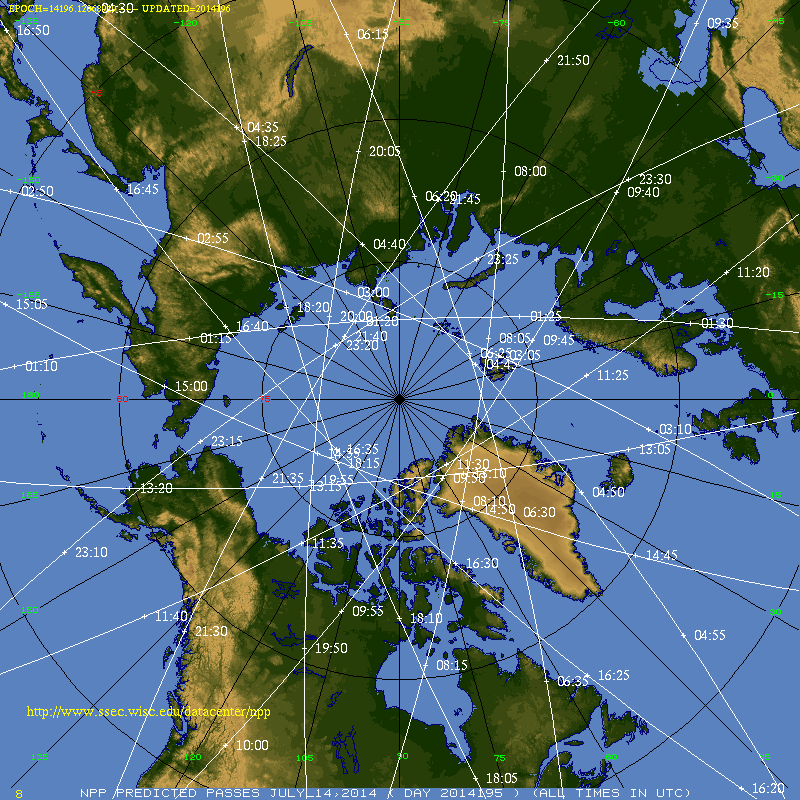

In [15]:
Image('https://www.ssec.wisc.edu/datacenter/npp/archive/ARCTIC/2014_07(182-212)/ARCTIC2014_07_14_195_npp.gif')

The paths are plotted in 5-min intervals, but the satellite captures 6-minute granules. For our source granule that has the closest match to the target Landsat-8 scene, acquisition starts at 14:42 UTC and goes till 14:48 UTC ; so the overpasses from both source and target acquisitions over our area of interest are likely within 2 or 3 minutes of one another.

In [16]:
# https://espg.keybase.pub/cloudmasking/CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc
f = h5py.File('./CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc')

In [17]:
list(f.keys())

['QA_dimension',
 'byte_segment',
 'geolocation_data',
 'geophysical_data',
 'number_of_lines',
 'number_of_pixels',
 'number_of_scans',
 'scan_line_attributes']

In [18]:
list(f['geophysical_data'])

['Clear_Sky_Confidence',
 'Cloud_Mask',
 'Integer_Cloud_Mask',
 'Quality_Assurance']

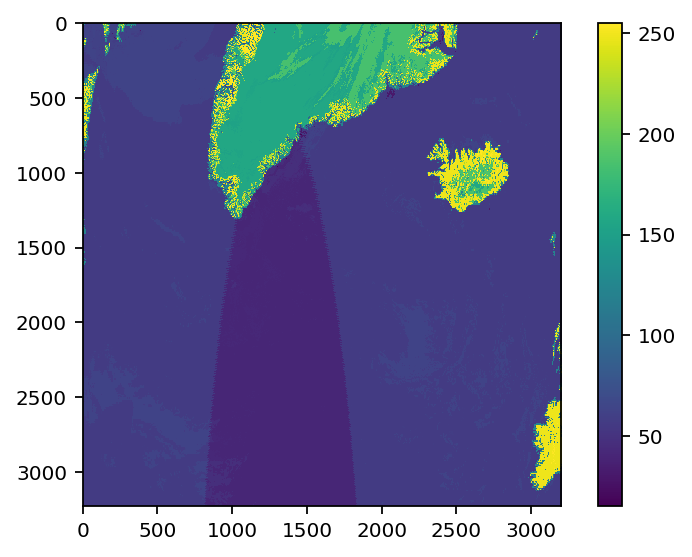

In [19]:
# Flip and mirror to show Greenland in more normal orientation
imshow(np.fliplr(np.flipud(f['geophysical_data']['Cloud_Mask'][0])))
colorbar()

array([0, 1, 2, 3], dtype=int8)

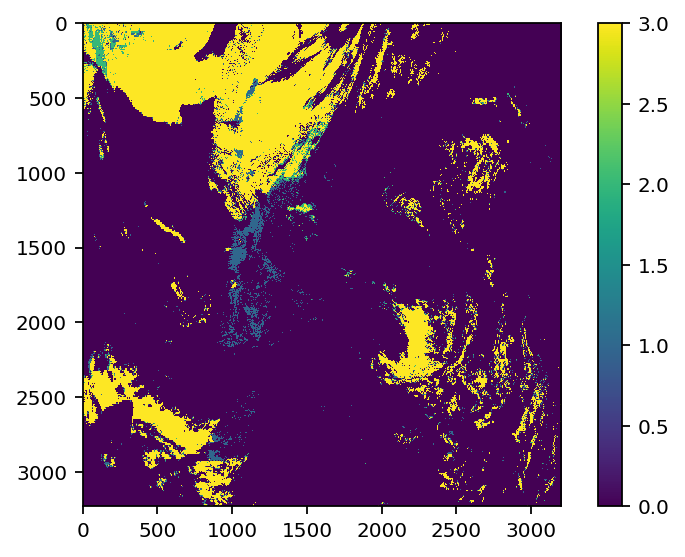

In [20]:
# Cloud mask data
# 0 is cloudy
# 1 is probably cloudy
# 2 is probably clear
# 3 is clear
imshow(np.fliplr(np.flipud(f['geophysical_data']['Integer_Cloud_Mask'])))
colorbar()
np.unique(f['geophysical_data']['Integer_Cloud_Mask'])

In [21]:
list(f['geolocation_data'])

['latitude',
 'longitude',
 'sensor_azimuth',
 'sensor_zenith',
 'solar_azimuth',
 'solar_zenith']

In [22]:
latE = np.array(f['geolocation_data']['latitude'])
lonE = np.array(f['geolocation_data']['longitude'])
clouds = np.array(f['geophysical_data']['Integer_Cloud_Mask'])

Lets get back to spatial queries for the Landsat image. Distance calculations are expensive if you do millions of them, so we'll coarsen the Landsat image by an order of magnitude to display the scene. This also makes sense given the plotting environment--displaying a ~9000 x ~9000 pixel image will just get binned anyway, so we might as well speed up the plots.

In [23]:
# Using 300 meter spacing for display
LSx_small , LSy_small = meshgrid(r_[ULX:ULX+(ds.RasterXSize*Xres):Xres*10], 
                                 r_[ULY:ULY+(ds.RasterYSize*Yres):Yres*10]) 
LScoords_small = np.vstack([LSx_small.ravel(),LSy_small.ravel()]).T
shape(LSx_small), shape(LSy_small)

((835, 828), (835, 828))

In [24]:
# Radians are needed to use haversine distances, which
# do spherical distance calculation correctly...
LS_rad_small = np.vstack(p2(LScoords_small[:,0], 
                            LScoords_small[:,1],inverse=True)).T
LS_rad_small *= pi/180      # to radians
VIIRS_rad = np.vstack([lonE[:].ravel(),latE[:].ravel()]).T
VIIRS_rad *= np.pi / 180.   # to radians

In [25]:
%%timeit
VIIRS_Ball = BallTree(VIIRS_rad,metric='haversine')
# VIIRS search object
# This is one of two 'heavy' computational steps

26.4 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
VIIRS_Ball = BallTree(VIIRS_rad,metric='haversine')

In [27]:
# We're going to determine, for each 'coarsened landsat 
# pseudo pixel', what the closest corresponding MODIS 
# pixel is. This will let us plot the MODIS pixels (source)
# at the same locations and extent as the target pixels

# return_dists=False, and breadth_first=True to speed up query
indiciesVIIRS = VIIRS_Ball.query(LS_rad_small, k=1, 
                                 breadth_first=True, 
                                 return_distance=False)

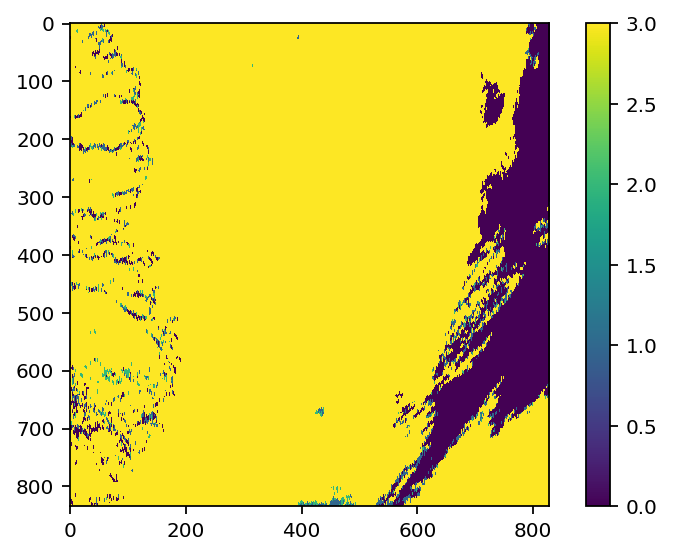

In [28]:
imshow(np.reshape(clouds[:].ravel()[indiciesVIIRS], (835, 828)))
colorbar()
# '0' (purple) is cloudy
# '3' (yellow) is clear

Pixel by pixel masking
---------------------------------

Above is a good visual indicator of how cloudy the scene is, but normally we want exact indices for masking data. To do this, we need exact pixel-to-pixel alignment and matching. There are two steps to this; building a spatial index tree, and then querying it. Above, we already (in cells 24-25) built the index tree on the VIIRS coords (the source coordinates), and used a ***small*** subset of the target coordinates to query. Since there are $8,271 * 8,341 = 68,988,411$ **total** Landsat pixels, we'll do some simple parallelization to speed things up, chunking the distance queries into blocks of 1 million points and distributing among however many cores our machine has. On our compute node with 28 cores, this takes about a minute; for my laptop with 4 cores, it takes between 7 and 10 minutes. There are also GPU options for distance queries-- see [this post](https://medium.com/aspectum/acceleration-for-the-nearest-neighbor-search-on-earths-surface-using-python-513fc75984aa) for some in depth ideas on speeding things up. 

In [29]:
c = 28    # Replace with your core count 
qq = lambda x: VIIRS_Ball.query(LS_rad[x*1000000:(x+1)*1000000], 
                                k=1, breadth_first=True, 
                                return_distance=False)

In [30]:
%%timeit
first = Parallel(n_jobs=c)(delayed(qq)(int(i)) for i in range(68))
second = VIIRS_Ball.query(LS_rad[68*1000000:], k=1,
                          breadth_first=True,
                          return_distance=False)

1min 4s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
first = Parallel(n_jobs=c)(delayed(qq)(int(i)) for i in range(68))
second = VIIRS_Ball.query(LS_rad[68*1000000:], k=1,
                          breadth_first=True,
                          return_distance=False)

Note that the previous cell is much more computationally intensive than I would expect compared to a library that would do this. We've grabbed the coordinates for ***all*** of the Landsat pixels (including the no data edge portions of the scene); normally you would just feed in your area of interest as a coordinate array. 

In [32]:
# smush all the indices together
ls_idx = np.concatenate((np.concatenate(first),second))

In [33]:
# Define conservative cloud mask-- only keep clear pixels
clouds_filter = ~(clouds[:] == 3)
# (we could leave in the 'probably clear' pixels with)
clouds_filter2 = (clouds[:] == 0) + (clouds[:] == 1)

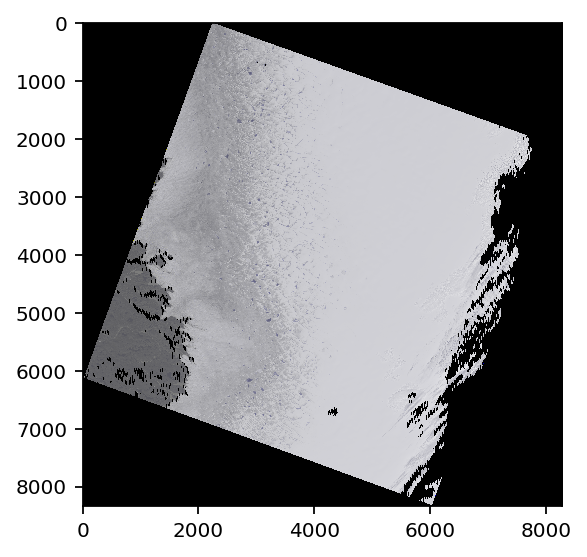

In [34]:
# We'll remove the clouds from the data array directly,
# replacing clouds with nans
final = np.copy(LSC)
final[np.reshape(clouds_filter.ravel()[ls_idx],
                (8341,8271)),0] = np.nan
final[np.reshape(clouds_filter.ravel()[ls_idx],
                (8341,8271)),1] = np.nan
final[np.reshape(clouds_filter.ravel()[ls_idx],
                (8341,8271)),2] = np.nan
imshow(final)

The cloud detection from VIIRS is based in part on liquid water detection; you can see that some outlet streams are wet enough to get masked as clouds, but not wet enough to get classified as stand alone water bodies. Fortunately, the lakes and melt ponds on the ice sheet are ***not*** identified as clouds. The eastern bank of clouds a well identified, although the resolution difference (750m vs 30m) is visible. 

How does this compare?
-----------------------------------

As I mentioned at the very top, the more common approach for sensors that have the spectral resolution for cloud detection is a sensor specific cloud mask. Landsat 1-7 lacked channels for detecting clouds, but Landsat 8 added a few targeted bands to enable cloud detection without using external data. The cloud mask for Landsat 8 isn't produced automatically; it is an on demand product that is delivered when you request calibrated reflectance retrieval from USGS. I grabbed the LS8 specific product for comparison-- you can grab it at:

[Just the aerosol cloudmask](https://espg.keybase.pub/cloudmasking/LC08_L1TP_006013_20140714_20170421_01_T1_sr_aerosol.tif)

[All the reflectance data](https://espg.keybase.pub/cloudmasking/LC080060132014071401T1-SC20200512165812.tar.gz)

In [35]:
# Read in the QA / aerosol band for LS8
# may take a sec to download depending on connection speed
qa = gdal.Open(aero_mask)

In [36]:
# define data mask
data_mask = ds.ReadAsArray(0) != 0

# LS8 clouds are coded as '8'; get them
LS8_QA = qa.ReadAsArray(0)==8

In [37]:
# The 'QA' band is 10 pixels shorter per side,
# and 5 pixels shorter top to bottom...
# ...which is a hassle...
np.shape(qa.ReadAsArray(0)), np.shape(ds.ReadAsArray(0))

((8321, 8261), (8341, 8271))

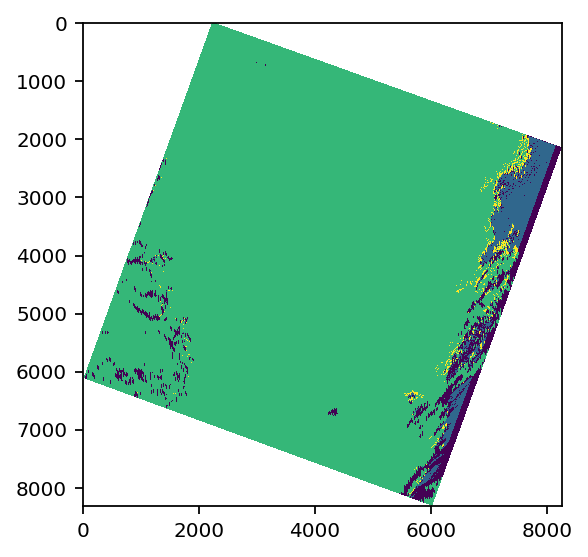

In [38]:
compare = np.zeros_like(qa.ReadAsArray(0), dtype=np.float32)
compare[~data_mask[10:-10,5:-5]] = np.nan
compare[data_mask[10:-10,5:-5]] += LS8_QA[data_mask[10:-10,5:-5]]*10
# Awful indexing
compare[data_mask[10:-10,5:-5]] -= np.reshape(clouds_filter.ravel()[ls_idx],
                      (8341,8271))[10:-10,5:-5][data_mask[10:-10,5:-5]]*20
imshow(compare)
# Purple is where VIIRS masks clouds, but LS8 doesn't
# Yellow is where LS8 masks clouds, but VIIRS doesn't
# Blue is where both mask clouds
# Green is where both agree that it is clear

Both the Landsat 8 cloud mask and VIIRS get the main, opaque cloud in the upper right hand corner; LS8 gets a bit more on the edges, but this could be a pixel size artifact (i.e., less then a full VIIRS pixel is cloud occupied). Regardless, it would be fairly simple to buffer the VIIRS mask to make the edges more conservative. There is a small VIIRS detected cloud at (X=4500, Y=6200), which given the similar shape to the LS8 cloud at (X=6000, Y=6000), makes me curious if is the same cloud... there is a bit of a temporal mismatch, and my guess is that cloud is at a different altitude than the rest of the bank and moving much faster.

Although the two mask agree in the upper right, I think that VIIRS may be more trustworthy in the lower right where there is disagreement. The LS8 mask is based off of brightness, and discrimination of white clouds from white snow by relying on other shortwave sources of spectral contrast. This is different from VIIRS, which is doing a full precipitable water inversion, and basing the classification off of water content (hence the VIIRS artifacts in the West of the image around streams). Looking at the original true color image, I think that VIIRS is more conservative than LS8 for a lot of the cloud bank, and may be more accurate for some of the less dense clouds-- although the spatial resolution is obviously not as high.

Overall though, the two mask agree pretty well, and both look like they do a decent job of masking clouds... although the risk adverse should buffer them for spectral retrievals.

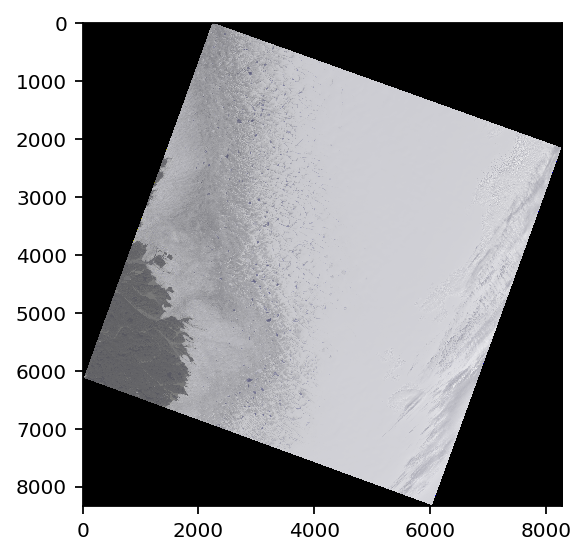

In [39]:
imshow(LSC)

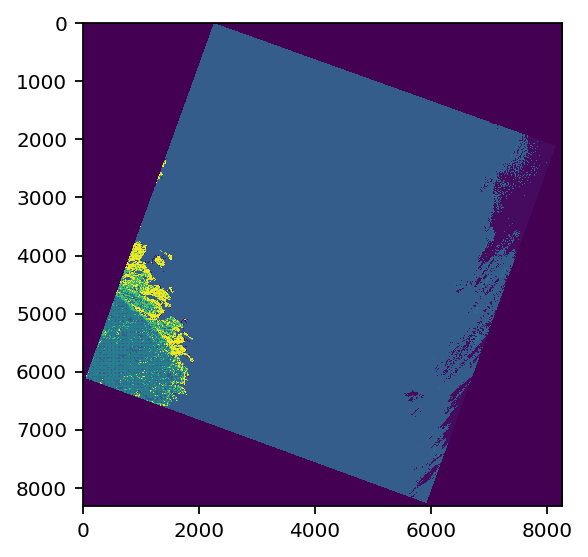

In [40]:
imshow(qa.ReadAsArray(0))

Next steps
----------

So if Landsat 8 has an on demand cloud mask that is passably good, why bother with all of this in the first place? Well, the main reason is that the same process works with other sensors that ***don't*** have in-sensor cloud detection capabilities. More explicitly, this includes both ICESat missions, *previous* Landsat missions (Landsat 5 and 7), Sentinel 2 (which lacks the thermal bands used by Landsat 8), and any sort of commercial imagery. Cloud masking for the ICESat missions is particularly challenging, as cloud attenuated signals can be easily misinterpreted as expressing different surface phenomenon (i.e., surface roughness).

Making a general purpose cloud masking library would ideally do a few things:

1. Automate selection of source granules
  - Hopefully in a way that has a sensible but overridable default
2. Enable definition of multiple/new cloud mask sources
  - I.e., be modular
3. Deal with spaciotemporal mismatches
  - E.g., by buffering, predicting cloud drift
4. Be fast
5. Be usable for other parameters
  - E.g., be able to grab optical thickness, etc.
6. Be flexible
  - Allow different coordinate options
  - Allow different distance metrics
  - be agnostic to raster or vector queries
7. Be easy
  - Get metadata directly from geotiffs or other input
  - Return masks without much code

For item 1 above, getting cloud compatible retrieval would be best... I think that MODIS granules are available on Google's cloud, but I'm not sure exactly what products, or how to access them.